<a href="https://colab.research.google.com/github/dulei711/sharing/blob/master/PAPJUDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

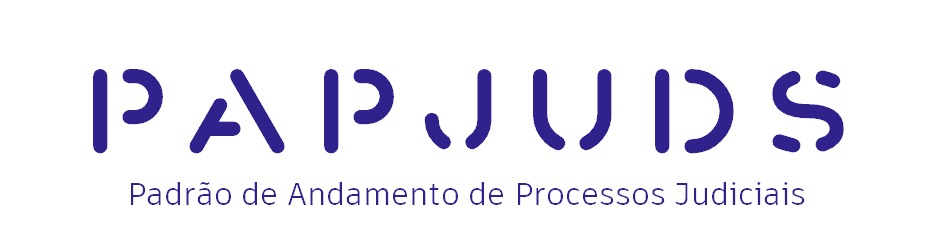

#DESAFIO 1 - CNJ

Não se sabe o padrão de andamento dos processos judiciais semelhantes em todas as unidades judiciárias, nas diferentes localidades e regiões do Brasil. 

A consequência direta é a dificuldade em proporcionar transparência, tanto interna quanto externa, necessária aos dados que são produzidos pelas unidades judiciárias, e a impossibilidade de gerenciar soluções para os gargalos, que não conseguem ser devidamente identificados.

* A equipe que escolher o DESAFIO 1 terá que pensar em soluções que fomentem a celeridade processual. 

A equipe deverá ainda:

* construir uma estratégia inteligente de controle interno de processos 
* e alertar sobre possíveis gargalos no tempo de tramitação processual;

* auxiliar na construção de um diagnóstico para oportunizar medidas assertivas a fim de permitir maior eficiência dos atos.

* A clusterização de unidades judiciárias semelhantes é particularmente importante, pois permite comparações nacionais, considerando suas características específicas. O modelo de classificação deve ser capaz de identificar os fatores de discriminação entre as unidades com base nos tipos processuais nas classes, nos assuntos, no fluxo dos processos, entre outros.

Fluxo ETL/DataOps

* ETL: Extract - Data Lake - Drive/CNJ
* ETL: Transform - JSON to Dataframe (Raw Zone)
* ETL: Load - JSON conversion to dataframe/csv (Trusted Zone)
* Feature engineering / DataPrep (Refined Zone)
* Machine Learning & Performance Analysis(Modelling)
* Dataviz (Sand Box Zone)

#MVP

* Utilizamos a base da justiça eleitoral devido ao tempo de processamento ser 
menor e possibilidade de espelhamento das mesmas técnicas aqui apresentadas a todas as outras áreas da justiça.

* Importante verificar a questão abordada no Desafio 2, a respeito da qualidade dos dados e compatibilidade das jurisdições, pois, há colunas de dados com pequenos "devios", caracteres que se não estiverem padronizados, podem atrapalhar o andamento das análises.

##Importação de bibliotecas e carregamento do Google Drive

In [ ]:
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pandas.io.json import json_normalize #package for flattening json in pandas df
from google.colab import drive
from sklearn import preprocessing

drive.mount('/content/drive')
frame = pd.DataFrame()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Função de planificação de estruturas hierárquicas JSON

In [ ]:
def flatten_nested_json_df(df):
    df = df.reset_index()
    #print(f"original shape: {df.shape}")
    #print(f"original columns: {df.columns}")
    # search for columns to explode/flatten
    s = (df.applymap(type) == list).all()
    list_columns = s[s].index.tolist()
    s = (df.applymap(type) == dict).all()
    dict_columns = s[s].index.tolist()
    #print(f"lists: {list_columns}, dicts: {dict_columns}")
    while len(list_columns) > 0 or len(dict_columns) > 0:
        new_columns = []
        for col in dict_columns:
            #print(f"flattening: {col}")
            # explode dictionaries horizontally, adding new columns
            horiz_exploded = pd.json_normalize(df[col]).add_prefix(f'{col}.')
            horiz_exploded.index = df.index
            df = pd.concat([df, horiz_exploded], axis=1).drop(columns=[col])
            new_columns.extend(horiz_exploded.columns) # inplace
        for col in list_columns:
            #print(f"exploding: {col}")
            # explode lists vertically, adding new columns
            df = df.drop(columns=[col]).join(df[col].explode().to_frame())
            new_columns.append(col)
        # check if there are still dict o list fields to flatten
        s = (df[new_columns].applymap(type) == list).all()
        list_columns = s[s].index.tolist()
        s = (df[new_columns].applymap(type) == dict).all()
        dict_columns = s[s].index.tolist()
        #print(f"lists: {list_columns}, dicts: {dict_columns}")
    #print(f"final shape: {df.shape}")
    #print(f"final columns: {df.columns}")
    return df

##Carregando tabelas SGT disponibilizadas pelo CNJ

In [ ]:
classes = pd.read_csv('/content/drive/My Drive/CNJ/sgt_classes.csv', sep=';')
movimentos = pd.read_csv('/content/drive/My Drive/CNJ/sgt_movimentos.csv', sep=';')
assuntos = pd.read_csv('/content/drive/My Drive/CNJ/sgt_assuntos.csv', sep=';')
serventias = pd.read_csv('/content/drive/My Drive/CNJ/mpm_serventias.csv', sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Visualizar a base de dados da tabela SGT - Classes

In [ ]:
classes.head()

,codigo,descricao,sigla,cod_pai,cod_filhos
0,2,PROCESSO CÍVEL E DO TRABALHO,ProcCivTrab,NaN,"158,175,197,214,1106,12133,159,165,169,1068,11..."
1,5,SUPERIOR TRIBUNAL DE JUSTIÇA,STJ,NaN,"1013,1015,1016,1017,1018,1019,1020,1021,1022,1..."
2,7,Procedimento Comum Cível,ProceComCiv,1107.0,NaN
3,22,Procedimento Sumário,ProSum,1107.0,NaN
4,26,Procedimentos Especiais,ProEsp,1107.0,"27,50,62,28,29,30,31,32,34,35,37,38,39,40,41,4..."


Visualizar a base de dados da tabela SGT - Movimentos

In [ ]:
movimentos.head()

,codigo,descricao,cod_pai,cod_filhos
0,1,Magistrado,NaN,"3,193,11009,7,11,25,56,63,83,108,113,117,122,1..."
1,3,Decisão,1.0,"7,11,25,56,63,83,108,113,117,122,133,138,146,1..."
2,7,Conversão,3.0,"266,821,12140,12473"
3,11,Declaração,3.0,"269,941,1003,12150,12151"
4,14,Serventuário,NaN,"15,18,48,104,865,12522,16,979,980,478,479,480,..."


Visualizar a base de dados da tabela SGT - Assuntos

In [ ]:
assuntos.head()

,codigo,descricao,cod_pai,cod_filhos
0,14,DIREITO TRIBUTÁRIO,NaN,"5913,5916,5956,5973,5978,5986,6017,6018,6021,6..."
1,195,DIREITO PREVIDENCIÁRIO,NaN,"6094,6119,6160,6173,6181,6095,6096,6099,6100,6..."
2,287,DIREITO PENAL,NaN,"3369,3385,3388,3394,3400,3405,3407,3412,3415,3..."
3,864,DIREITO DO TRABALHO,NaN,"1654,1658,1695,1697,1937,2135,2567,2581,2620,2..."
4,899,DIREITO CIVIL,NaN,"5626,5754,7673,7681,7947,9616,9981,10431,10432..."


Visualizar a base de dados da tabela MPM - Serventias

In [ ]:
serventias.head()

,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,SEQ_CIDADE,DSC_CIDADE,SIG_UF,COD_IBGE,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,DSC_ORGAO,DSC_DENOM_SERVENTIA_JUDICIAL,endereco_serventia,cep_serventia,LATITUDE,LONGITUDE
0,1,Conselho Nacional de Justiça,NaN,CNJ,743.0,BRASÍLIA,DF,5300108.0,Conselho Nacional de Justiça,S,0.0,Conselho Nacional de Justiça,NaN,NaN,NaN,NaN,NaN
1,2,Conselho da Justiça Federal,1.0,CONSF,743.0,BRASÍLIA,DF,5300108.0,Conselho da Justiça Federal,F,0.0,Conselho da Justiça Federal,NaN,NaN,NaN,NaN,NaN
2,3,Tribunal Regional Federal da 1ª Região,2.0,TRIBF,743.0,BRASÍLIA,DF,5300108.0,Tribunal Regional Federal,F,NaN,Tribunal Regional Federal da 1ª Região,NaN,NaN,NaN,NaN,NaN
3,4,Tribunal Regional Federal da 2ª Região,2.0,TRIBF,4155.0,RIO DE JANEIRO,RJ,3304557.0,Tribunal Regional Federal,F,NaN,Tribunal Regional Federal da 2ª Região,NaN,NaN,NaN,NaN,NaN
4,5,Tribunal Regional Federal da 3ª Região,2.0,TRIBF,4795.0,SAO PAULO,SP,3550308.0,Tribunal Regional Federal,F,NaN,Tribunal Regional Federal da 3ª Região,NaN,NaN,NaN,1050182067,607162856


##Manipulação da base da justiça

Carregamento dos arquivos JSON do Google Drive e atribuição a um DataFrame

In [ ]:
df = pd.DataFrame()


for root, dirs, files in os.walk("/content/drive/My Drive/CNJ/justica_eleitoral"):
    for name in files:
      full_path = os.path.join(root, name)
      tmp_frame = pd.read_json(full_path, orient='data')
      df = df.append(tmp_frame)
      print(full_path)
      del tmp_frame
      del full_path

/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-ac_1.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-ac_2.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-ac_3.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-al_1.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-al_2.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-am_1.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-al_3.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-am_3.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-am_2.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-ap_1.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-ap_2.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-ap_3.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-ba_1.json
/content/drive/My Drive/CNJ/justica_eleitoral/processos-tre-ba_2.json
/content/drive/My Dr

Visualização do Dataframe com 5 colunas, sendo duas delas hierarquizadas

In [ ]:
df.head()

,millisInsercao,dadosBasicos,siglaTribunal,movimento,grau
0,1601915752207,"{'assunto': [{'principal': False, 'codigoNacio...",TRE-AC,"[{'identificadorMovimento': '399179', 'tipoRes...",G2
1,1601915787787,"{'assunto': [{'principal': False, 'codigoNacio...",TRE-AC,"[{'identificadorMovimento': '422485', 'tipoRes...",G2
2,1601915785373,"{'assunto': [{'principal': False, 'codigoNacio...",TRE-AC,"[{'identificadorMovimento': '425961', 'tipoRes...",G2
3,1601915755978,"{'assunto': [{'principal': False, 'codigoNacio...",TRE-AC,"[{'identificadorMovimento': '400029', 'tipoRes...",G2
4,1601915767014,"{'assunto': [{'principal': False, 'codigoNacio...",TRE-AC,"[{'identificadorMovimento': '400406', 'tipoRes...",G2


Aplicação da função de planificação dno DataFrame

In [ ]:
dff = flatten_nested_json_df(df)
del df

Visualização do DataFrame com 23 colunas, restando ainda uma hierarquizada

In [ ]:
dff.head()

,index,millisInsercao,siglaTribunal,movimento,grau,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.tamanhoProcesso,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.classeProcessual,dadosBasicos.nivelSigilo,dadosBasicos.competencia,dadosBasicos.codigoLocalidade,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoMunicipioIBGE,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,dadosBasicos.valorCausa
0,0,1601915752207,TRE-AC,"[{'identificadorMovimento': '399179', 'tipoRes...",G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN
1,1,1601915787787,TRE-AC,"[{'identificadorMovimento': '422485', 'tipoRes...",G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00001262020006010000,2.0,20000117085100,1.0,11528,0,2.0,1200401,Gabinete do Juiz de Direito 1,1200401,78484,ORIG,NaN
2,2,1601915785373,TRE-AC,"[{'identificadorMovimento': '425961', 'tipoRes...",G2,"[{'principal': False, 'codigoNacional': 12046}]",8,-1.0,00013277620026010000,2.0,20020502140400,1.0,11531,0,2.0,1200401,Gabinete do Juiz de Direito 1,1200401,78484,ORIG,NaN
3,3,1601915755978,TRE-AC,"[{'identificadorMovimento': '400029', 'tipoRes...",G2,"[{'principal': False, 'codigoNacional': 12363}]",8,-1.0,00000537720026010000,2.0,20020706135900,1.0,11532,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN
4,4,1601915767014,TRE-AC,"[{'identificadorMovimento': '400406', 'tipoRes...",G2,"[{'principal': False, 'codigoNacional': 12363}]",8,-1.0,00002182720026010000,2.0,20020706172100,1.0,11532,0,2.0,1200401,Gabinete do Jurista 1,1200401,78486,ORIG,NaN


Identificação de lista de dicionários na coluna "movimento" e ativação de função para quebrar essa estrutura em um DataFrame à parte

In [ ]:
df1 = pd.concat([pd.DataFrame(i) for i in dff.movimento], keys = dff.index).reset_index(level=1,drop=True)

Junção do DataFrame "df1" ao original "dff"

In [ ]:
dff = dff.drop('movimento', axis=1).join(df1).reset_index(drop=True)

Visualização do DataFrame sem estruturas hierarquizadas em "movimento"

In [ ]:
dff.head()

,index,millisInsercao,siglaTribunal,grau,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.tamanhoProcesso,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.classeProcessual,dadosBasicos.nivelSigilo,dadosBasicos.competencia,dadosBasicos.codigoLocalidade,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoMunicipioIBGE,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,dadosBasicos.valorCausa,identificadorMovimento,tipoResponsavelMovimento,movimentoNacional,dataHora,tipoDecisao,orgaoJulgador,nivelSigilo,complementoNacional,idDocumentoVinculado,movimentoLocal
0,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,399179,0,{'codigoNacional': 11383},20000113074300,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,399180,0,{'codigoNacional': 11383},20000113074300,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84853,0,{'codigoNacional': 11383},20000113074400,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84953,0,{'codigoNacional': 11383},20000113081800,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84897,0,{'codigoNacional': 11383},20000113081900,NaN,NaN,NaN,NaN,NaN,NaN


Exclusão de linhas que não contenham código de movimento nacional e planificação da estrutura de "movimento nacional"

In [ ]:
dff = dff[dff['movimentoNacional'].notna()]
dff = flatten_nested_json_df(dff)
dff.head()

,level_0,index,millisInsercao,siglaTribunal,grau,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.tamanhoProcesso,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.classeProcessual,dadosBasicos.nivelSigilo,dadosBasicos.competencia,dadosBasicos.codigoLocalidade,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoMunicipioIBGE,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,dadosBasicos.valorCausa,identificadorMovimento,tipoResponsavelMovimento,dataHora,tipoDecisao,orgaoJulgador,nivelSigilo,complementoNacional,idDocumentoVinculado,movimentoLocal,movimentoNacional.codigoNacional
0,0,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,399179,0,20000113074300,NaN,NaN,NaN,NaN,NaN,NaN,11383
1,1,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,399180,0,20000113074300,NaN,NaN,NaN,NaN,NaN,NaN,11383
2,2,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84853,0,20000113074400,NaN,NaN,NaN,NaN,NaN,NaN,11383
3,3,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84953,0,20000113081800,NaN,NaN,NaN,NaN,NaN,NaN,11383
4,4,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,20000113074300,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84897,0,20000113081900,NaN,NaN,NaN,NaN,NaN,NaN,11383


## Feature Engineering / DataPrep

Transformação de tipos de dados de data

In [ ]:
dff['dataHora'] = pd.to_datetime(dff['dataHora'], errors='coerce')
dff['dadosBasicos.dataAjuizamento'] = pd.to_datetime(dff['dadosBasicos.dataAjuizamento'], errors='coerce')

In [ ]:
dff

,level_0,index,millisInsercao,siglaTribunal,grau,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.tamanhoProcesso,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.classeProcessual,dadosBasicos.nivelSigilo,dadosBasicos.competencia,dadosBasicos.codigoLocalidade,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoMunicipioIBGE,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,dadosBasicos.valorCausa,identificadorMovimento,tipoResponsavelMovimento,dataHora,tipoDecisao,orgaoJulgador,nivelSigilo,complementoNacional,idDocumentoVinculado,movimentoLocal,movimentoNacional.codigoNacional
0,0,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,399179,0,2000-01-13 07:43:00,NaN,NaN,NaN,NaN,NaN,NaN,11383
1,1,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,399180,0,2000-01-13 07:43:00,NaN,NaN,NaN,NaN,NaN,NaN,11383
2,2,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84853,0,2000-01-13 07:44:00,NaN,NaN,NaN,NaN,NaN,NaN,11383
3,3,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84953,0,2000-01-13 08:18:00,NaN,NaN,NaN,NaN,NaN,NaN,11383
4,4,0,1601915752207,TRE-AC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84897,0,2000-01-13 08:19:00,NaN,NaN,NaN,NaN,NaN,NaN,11383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137191,3201435,1999,1600497102945,TRE-TO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,-1.0,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,0,1.0,1705508,4ª ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,1705508,16926,ORIG,NaN,948070,0,2020-09-01 07:47:00,NaN,{'nomeOrgao': '4ª ZONA ELEITORAL - COLINAS DO ...,NaN,NaN,NaN,NaN,60
3137192,3201436,1999,1600497102945,TRE-TO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,-1.0,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,0,1.0,1705508,4ª ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,1705508,16926,ORIG,NaN,951506,0,2020-09-03 11:57:00,NaN,{'nomeOrgao': '4ª ZONA ELEITORAL - COLINAS DO ...,NaN,NaN,NaN,NaN,60
3137193,3201437,1999,1600497102945,TRE-TO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,-1.0,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,0,1.0,1705508,4ª ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,1705508,16926,ORIG,NaN,951507,0,2020-09-03 11:57:00,NaN,{'nomeOrgao': '4ª ZONA ELEITORAL - COLINAS DO ...,NaN,NaN,NaN,NaN,60
3137194,3201438,1999,1600497102945,TRE-TO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,-1.0,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,0,1.0,1705508,4ª ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,1705508,16926,ORIG,NaN,951918,1,2020-09-03 22:41:00,NaN,{'nomeOrgao': '4ª ZONA ELEITORAL - COLINAS DO ...,NaN,NaN,NaN,NaN,92


Criação da variável "tempo_dias", que é equivalente ao tempo desde o ajuizamento até o movimento relativo à linha do DataFrame

In [ ]:
dff['tempo_dias']=dff['dataHora']-dff['dadosBasicos.dataAjuizamento']
dff['tempo_dias'] = pd.to_numeric(dff['tempo_dias'].dt.days, downcast='integer')
dff['tempo_dias'] = abs(dff['tempo_dias'])/365
dff['siglaTribunal'] = dff['siglaTribunal'].str.replace("-", "")
dff["dadosBasicos.orgaoJulgador.nomeOrgao"] = dff["dadosBasicos.orgaoJulgador.nomeOrgao"].str.replace(" ª", "ª")
dff["dadosBasicos.orgaoJulgador.nomeOrgao"] = dff["dadosBasicos.orgaoJulgador.nomeOrgao"].str.replace("ª", "")

In [ ]:
dff.head()

,level_0,index,millisInsercao,siglaTribunal,grau,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.tamanhoProcesso,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.classeProcessual,dadosBasicos.nivelSigilo,dadosBasicos.competencia,dadosBasicos.codigoLocalidade,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoMunicipioIBGE,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,dadosBasicos.valorCausa,identificadorMovimento,tipoResponsavelMovimento,dataHora,tipoDecisao,orgaoJulgador,nivelSigilo,complementoNacional,idDocumentoVinculado,movimentoLocal,movimentoNacional.codigoNacional,tempo_dias
0,0,0,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,399179,0,2000-01-13 07:43:00,NaN,NaN,NaN,NaN,NaN,NaN,11383,0.0
1,1,0,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,399180,0,2000-01-13 07:43:00,NaN,NaN,NaN,NaN,NaN,NaN,11383,0.0
2,2,0,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84853,0,2000-01-13 07:44:00,NaN,NaN,NaN,NaN,NaN,NaN,11383,0.0
3,3,0,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84953,0,2000-01-13 08:18:00,NaN,NaN,NaN,NaN,NaN,NaN,11383,0.0
4,4,0,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,-1.0,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,0,2.0,1200401,Gabinete do Jurista 2,1200401,78487,ORIG,NaN,84897,0,2000-01-13 08:19:00,NaN,NaN,NaN,NaN,NaN,NaN,11383,0.0


Alimentação do DataFrame principal com as informações de classe processual, movimento e assunto, relativos às tabelas SGT

In [ ]:
dff['classeProcessual'] = dff['dadosBasicos.classeProcessual'].map(classes.set_index('codigo')['descricao'])
dff['movimento'] = dff['movimentoNacional.codigoNacional'].map(movimentos.set_index('codigo')['descricao'])

Exclusão de colunas que não terão influencia na modelagem de dados

In [ ]:
dff = dff.drop(['dadosBasicos.nivelSigilo', 'dadosBasicos.tamanhoProcesso', 'tipoResponsavelMovimento', 'orgaoJulgador', 'complementoNacional', 'idDocumentoVinculado'], axis=1)
dff = dff.drop(['level_0', 'index', 'dadosBasicos.competencia', 'dadosBasicos.valorCausa', 'dadosBasicos.orgaoJulgador.codigoMunicipioIBGE'], axis=1)

In [ ]:
dff.head()

,millisInsercao,siglaTribunal,grau,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.classeProcessual,dadosBasicos.codigoLocalidade,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,identificadorMovimento,dataHora,tipoDecisao,nivelSigilo,movimentoLocal,movimentoNacional.codigoNacional,tempo_dias,classeProcessual,movimento
0,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,399179,2000-01-13 07:43:00,NaN,NaN,NaN,11383,0.0,Processo Administrativo,Ato ordinatório
1,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,399180,2000-01-13 07:43:00,NaN,NaN,NaN,11383,0.0,Processo Administrativo,Ato ordinatório
2,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,84853,2000-01-13 07:44:00,NaN,NaN,NaN,11383,0.0,Processo Administrativo,Ato ordinatório
3,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,84953,2000-01-13 08:18:00,NaN,NaN,NaN,11383,0.0,Processo Administrativo,Ato ordinatório
4,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,84897,2000-01-13 08:19:00,NaN,NaN,NaN,11383,0.0,Processo Administrativo,Ato ordinatório


##DataPrep para modelagem

Exclusão de colunas completamente vazias

In [ ]:
dff.dropna(axis=1, how='all', inplace=True)

Substituição de valores nulos por "0"

In [ ]:
dff = dff.fillna(0)

In [ ]:
dff

,millisInsercao,siglaTribunal,grau,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.classeProcessual,dadosBasicos.codigoLocalidade,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,identificadorMovimento,dataHora,tipoDecisao,nivelSigilo,movimentoNacional.codigoNacional,tempo_dias,classeProcessual,movimento
0,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,399179,2000-01-13 07:43:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório
1,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,399180,2000-01-13 07:43:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório
2,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,84853,2000-01-13 07:44:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório
3,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,84953,2000-01-13 08:18:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório
4,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,84897,2000-01-13 08:19:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137191,1600497102945,TRETO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,1705508,4 ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,16926,ORIG,948070,2020-09-01 07:47:00,0,0.0,60,0.021918,Prestação de Contas Anual,Expedição de documento
3137192,1600497102945,TRETO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,1705508,4 ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,16926,ORIG,951506,2020-09-03 11:57:00,0,0.0,60,0.027397,Prestação de Contas Anual,Expedição de documento
3137193,1600497102945,TRETO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,1705508,4 ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,16926,ORIG,951507,2020-09-03 11:57:00,0,0.0,60,0.027397,Prestação de Contas Anual,Expedição de documento
3137194,1600497102945,TRETO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,1705508,4 ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,16926,ORIG,951918,2020-09-03 22:41:00,0,0.0,92,0.027397,Prestação de Contas Anual,Publicação


Identificação das regras de negócio elegidas pela equipe: Trânsito em Julgado

In [ ]:
dff['transito_julgado']=0
dff.loc[dff['movimentoNacional.codigoNacional'] == 848, 'transito_julgado'] = 1

Identificação das regras de negócio elegidas pela equipe: Até Audiência de instrução e julgamento

In [ ]:
dff['AIJ']=0
dff.loc[dff['movimentoNacional.codigoNacional'] == 12739, 'AIJ'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12743, 'AIJ'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12749, 'AIJ'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12750, 'AIJ'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12751, 'AIJ'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12747, 'AIJ'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12748, 'AIJ'] = 1

Identificação das regras de negócio elegidas pela equipe: Processos extintos sem julgamento de mérito


In [ ]:
dff['Extinto_sem_merito']=0
dff.loc[dff['movimentoNacional.codigoNacional'] == 457, 'Extinto_sem_merito'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 458, 'Extinto_sem_merito'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11376, 'Extinto_sem_merito'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11380, 'Extinto_sem_merito'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12325, 'Extinto_sem_merito'] = 1

Identificação das regras de negócio elegidas pela equipe: Recursos pós extinção

In [ ]:
dff['Recursos_pos_extincao']=0
dff.loc[dff['movimentoNacional.codigoNacional'] == 381, 'Recursos_pos_extincao'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 804, 'Recursos_pos_extincao'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1060, 'Recursos_pos_extincao'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12445, 'Recursos_pos_extincao'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12456, 'Recursos_pos_extincao'] = 1

Identificação das regras de negócio elegidas pela equipe: Número de homologação de acordo / conciliação

In [ ]:
dff['Acordo']=0
dff.loc[dff['movimentoNacional.codigoNacional'] == 377, 'Acordo'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12733, 'Acordo'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12740, 'Acordo'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12752, 'Acordo'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12753, 'Acordo'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12614, 'Acordo'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12618, 'Acordo'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12622, 'Acordo'] = 1

Identificação das regras de negócio elegidas pela equipe: Processo Ativo

In [ ]:
dff['Ativo']=1
dff.loc[dff['movimentoNacional.codigoNacional'] == 848, 'Ativo'] = 0
dff.loc[dff['movimentoNacional.codigoNacional'] == 228, 'Ativo'] = 0
dff.loc[dff['movimentoNacional.codigoNacional'] == 861, 'Ativo'] = 0
dff.loc[dff['movimentoNacional.codigoNacional'] == 12430, 'Ativo'] = 0
dff.loc[dff['movimentoNacional.codigoNacional'] == 893, 'Ativo'] = 1

Identificação das regras de negócio elegidas pela equipe: Despacho

In [ ]:
dff['Despacho']=0
dff.loc[dff['movimentoNacional.codigoNacional'] == 3, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 7, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 25, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 56, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 63, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 83, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 108, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 113, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 117, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 122, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 133, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 138, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 146, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 151, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 160, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 163, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 172, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 190, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 206, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 207, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 378, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 817, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 888, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 961, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 968, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1008, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1013, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12067, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12092, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12093, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12141, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12144, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12163, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12164, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12185, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12206, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12208, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12210, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12299, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12300, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12307, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12318, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12320, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12332, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12359, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12387, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12425, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12432, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12444, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12455, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12477, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12647, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12736, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12765, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12768, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12769, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 128, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 175, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 263, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 264, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 265, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 266, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 268, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 269, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 270, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 275, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 276, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 277, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 278, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 279, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 334, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 335, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 347, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 348, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 349, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 352, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 353, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 354, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 355, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 357, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 358, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 371, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 373, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 374, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 377, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 381, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 383, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 399, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 400, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 402, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 404, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 429, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 430, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 431, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 432, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 433, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 434, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 785, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 788, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 792, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 799, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 803, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 804, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 821, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 823, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 824, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 898, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 940, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 941, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 944, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 945, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 947, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 960, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 971, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1003, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1004, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1009, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1010, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1011, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 1014, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1015, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1016, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1018, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1019, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1063, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 10962, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11002, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 11011, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11012, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11013, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11014, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11016, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11017, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11018, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11022, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 11382, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11393, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11425, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11426, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11792, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 11975, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12033, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12034, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12036, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12037, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12038, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12039, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12040, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12094, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12095, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12096, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12097, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12098, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12099, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12100, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12140, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12145, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12146, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12147, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12150, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12151, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12188, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12207, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12209, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12211, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12213, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12255, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12301, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12302, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12303, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12304, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12305, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12306, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12421, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12422, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12427, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12428, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12429, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12430, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12431, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12445, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12446, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12447, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12448, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12454, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12456, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12457, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12467, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12472, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12473, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12474, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12476, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12478, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12479, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12646, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12648, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12733, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12734, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12737, 'Despacho'] = 1

dff.loc[dff['movimentoNacional.codigoNacional'] == 12766, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12767, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 394, 'Despacho'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 1059, 'Despacho'] = 1

Identificação das regras de negócio elegidas pela equipe: Ato Ordinatório

In [ ]:
dff['Ato_Ordinatorio']=0
dff.loc[dff['movimentoNacional.codigoNacional'] == 11383, 'Ato_Ordinatorio'] = 1

Identificação das regras de negócio elegidas pela equipe: Remessa 

In [ ]:
dff['Remessa']=0
dff.loc[dff['movimentoNacional.codigoNacional'] == 123, 'Remessa'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 978, 'Remessa'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 980, 'Remessa'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 982, 'Remessa'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12167, 'Remessa'] = 1
dff.loc[dff['movimentoNacional.codigoNacional'] == 12174, 'Remessa'] = 1

In [ ]:
dff

,millisInsercao,siglaTribunal,grau,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.classeProcessual,dadosBasicos.codigoLocalidade,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,identificadorMovimento,dataHora,tipoDecisao,nivelSigilo,movimentoNacional.codigoNacional,tempo_dias,classeProcessual,movimento,transito_julgado,AIJ,Extinto_sem_merito,Recursos_pos_extincao,Acordo,Ativo,Despacho,Ato_Ordinatorio,Remessa
0,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,399179,2000-01-13 07:43:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório,0,0,0,0,0,1,0,1,0
1,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,399180,2000-01-13 07:43:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório,0,0,0,0,0,1,0,1,0
2,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,84853,2000-01-13 07:44:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório,0,0,0,0,0,1,0,1,0
3,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,84953,2000-01-13 08:18:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório,0,0,0,0,0,1,0,1,0
4,1601915752207,TREAC,G2,"[{'principal': False, 'codigoNacional': 11778}]",8,00000258020006010000,2.0,2000-01-13 07:43:00,1.0,1298,1200401,Gabinete do Jurista 2,78487,ORIG,84897,2000-01-13 08:19:00,0,0.0,11383,0.000000,Processo Administrativo,Ato ordinatório,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137191,1600497102945,TRETO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,1705508,4 ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,16926,ORIG,948070,2020-09-01 07:47:00,0,0.0,60,0.021918,Prestação de Contas Anual,Expedição de documento,0,0,0,0,0,1,0,0,0
3137192,1600497102945,TRETO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,1705508,4 ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,16926,ORIG,951506,2020-09-03 11:57:00,0,0.0,60,0.027397,Prestação de Contas Anual,Expedição de documento,0,0,0,0,0,1,0,0,0
3137193,1600497102945,TRETO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,1705508,4 ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,16926,ORIG,951507,2020-09-03 11:57:00,0,0.0,60,0.027397,Prestação de Contas Anual,Expedição de documento,0,0,0,0,0,1,0,0,0
3137194,1600497102945,TRETO,G1,"[{'principal': False, 'codigoNacional': 12048}]",1,06003090320206270004,1.0,2020-08-24 00:00:00,1.0,12377,1705508,4 ZONA ELEITORAL - COLINAS DO TOCANTINS/TO,16926,ORIG,951918,2020-09-03 22:41:00,0,0.0,92,0.027397,Prestação de Contas Anual,Publicação,0,0,0,0,0,1,0,0,0


Definição da base para modelagem de Machine Learning

Salvando DataFrame em csv para posterior DataViz em plataforma de Business Intelligence

In [ ]:
compression_opts = dict(method='zip', archive_name='dff.csv')  
dff.to_csv('dff.zip', index=False, compression=compression_opts)

Possíveis visualizações das variáveis por orgao

In [ ]:
pd.crosstab(dff['dadosBasicos.orgaoJulgador.nomeOrgao'] , dff['transito_julgado'])

transito_julgado,0,1
dadosBasicos.orgaoJulgador.nomeOrgao,,
0,2797,26
,5703,79
0 ASSESSORIA JUDICIÁRIA DA PRESIDÊNCIA,342,0
0 ASSESSORIA JURÍDICA E CORRECIONAL DA CORREGEDORIA REGIONAL ELEITORAL,153,1
0 CARTÓRIO DA 35 ZONA ELEITORAL,435,9
...,...,...
VICE-PRESIDÊNCIA E CORREGEDORIA,841,5
VICENTE LOPES DA ROCHA JÚNIOR - Jurista 2,192,5
Vice-Presidente - Desembargador Sebastião Barbosa Farias,1595,14


In [ ]:
pd.crosstab(dff['dadosBasicos.orgaoJulgador.nomeOrgao'] , dff['AIJ'])

AIJ,0,1
dadosBasicos.orgaoJulgador.nomeOrgao,,
0,2823,0
,5782,0
0 ASSESSORIA JUDICIÁRIA DA PRESIDÊNCIA,342,0
0 ASSESSORIA JURÍDICA E CORRECIONAL DA CORREGEDORIA REGIONAL ELEITORAL,154,0
0 CARTÓRIO DA 35 ZONA ELEITORAL,444,0
...,...,...
VICE-PRESIDÊNCIA E CORREGEDORIA,846,0
VICENTE LOPES DA ROCHA JÚNIOR - Jurista 2,197,0
Vice-Presidente - Desembargador Sebastião Barbosa Farias,1609,0


In [ ]:
pd.crosstab(dff['dadosBasicos.orgaoJulgador.nomeOrgao'] , dff['Extinto_sem_merito'])

Extinto_sem_merito,0,1
dadosBasicos.orgaoJulgador.nomeOrgao,,
0,2823,0
,5782,0
0 ASSESSORIA JUDICIÁRIA DA PRESIDÊNCIA,342,0
0 ASSESSORIA JURÍDICA E CORRECIONAL DA CORREGEDORIA REGIONAL ELEITORAL,154,0
0 CARTÓRIO DA 35 ZONA ELEITORAL,444,0
...,...,...
VICE-PRESIDÊNCIA E CORREGEDORIA,846,0
VICENTE LOPES DA ROCHA JÚNIOR - Jurista 2,197,0
Vice-Presidente - Desembargador Sebastião Barbosa Farias,1609,0


In [ ]:
pd.crosstab(dff['dadosBasicos.orgaoJulgador.nomeOrgao'] , dff['Recursos_pos_extincao'])

Recursos_pos_extincao,0,1
dadosBasicos.orgaoJulgador.nomeOrgao,,
0,2823,0
,5782,0
0 ASSESSORIA JUDICIÁRIA DA PRESIDÊNCIA,342,0
0 ASSESSORIA JURÍDICA E CORRECIONAL DA CORREGEDORIA REGIONAL ELEITORAL,154,0
0 CARTÓRIO DA 35 ZONA ELEITORAL,444,0
...,...,...
VICE-PRESIDÊNCIA E CORREGEDORIA,846,0
VICENTE LOPES DA ROCHA JÚNIOR - Jurista 2,197,0
Vice-Presidente - Desembargador Sebastião Barbosa Farias,1609,0


In [ ]:
pd.crosstab(dff['dadosBasicos.orgaoJulgador.nomeOrgao'] , dff['Acordo'])

Acordo,0,1
dadosBasicos.orgaoJulgador.nomeOrgao,,
0,2823,0
,5782,0
0 ASSESSORIA JUDICIÁRIA DA PRESIDÊNCIA,342,0
0 ASSESSORIA JURÍDICA E CORRECIONAL DA CORREGEDORIA REGIONAL ELEITORAL,154,0
0 CARTÓRIO DA 35 ZONA ELEITORAL,444,0
...,...,...
VICE-PRESIDÊNCIA E CORREGEDORIA,846,0
VICENTE LOPES DA ROCHA JÚNIOR - Jurista 2,197,0
Vice-Presidente - Desembargador Sebastião Barbosa Farias,1609,0


In [ ]:
pd.crosstab(dff['dadosBasicos.orgaoJulgador.nomeOrgao'] , dff['Ativo'])

Ativo,0,1
dadosBasicos.orgaoJulgador.nomeOrgao,,
0,37,2786
,110,5672
0 ASSESSORIA JUDICIÁRIA DA PRESIDÊNCIA,0,342
0 ASSESSORIA JURÍDICA E CORRECIONAL DA CORREGEDORIA REGIONAL ELEITORAL,1,153
0 CARTÓRIO DA 35 ZONA ELEITORAL,9,435
...,...,...
VICE-PRESIDÊNCIA E CORREGEDORIA,5,841
VICENTE LOPES DA ROCHA JÚNIOR - Jurista 2,6,191
Vice-Presidente - Desembargador Sebastião Barbosa Farias,14,1595


In [ ]:
pd.crosstab(dff['dadosBasicos.orgaoJulgador.nomeOrgao'] , dff['Despacho'])

Despacho,0,1
dadosBasicos.orgaoJulgador.nomeOrgao,,
0,2764,59
,5604,178
0 ASSESSORIA JUDICIÁRIA DA PRESIDÊNCIA,341,1
0 ASSESSORIA JURÍDICA E CORRECIONAL DA CORREGEDORIA REGIONAL ELEITORAL,151,3
0 CARTÓRIO DA 35 ZONA ELEITORAL,444,0
...,...,...
VICE-PRESIDÊNCIA E CORREGEDORIA,846,0
VICENTE LOPES DA ROCHA JÚNIOR - Jurista 2,189,8
Vice-Presidente - Desembargador Sebastião Barbosa Farias,1607,2


In [ ]:
pd.crosstab(dff['dadosBasicos.orgaoJulgador.nomeOrgao'] , dff['Ato_Ordinatorio'])

Ato_Ordinatorio,0,1
dadosBasicos.orgaoJulgador.nomeOrgao,,
0,2305,518
,4679,1103
0 ASSESSORIA JUDICIÁRIA DA PRESIDÊNCIA,237,105
0 ASSESSORIA JURÍDICA E CORRECIONAL DA CORREGEDORIA REGIONAL ELEITORAL,114,40
0 CARTÓRIO DA 35 ZONA ELEITORAL,444,0
...,...,...
VICE-PRESIDÊNCIA E CORREGEDORIA,846,0
VICENTE LOPES DA ROCHA JÚNIOR - Jurista 2,197,0
Vice-Presidente - Desembargador Sebastião Barbosa Farias,1545,64


In [ ]:
pd.crosstab(dff['dadosBasicos.orgaoJulgador.nomeOrgao'] , dff['Remessa'])

Remessa,0,1
dadosBasicos.orgaoJulgador.nomeOrgao,,
0,2725,98
,5520,262
0 ASSESSORIA JUDICIÁRIA DA PRESIDÊNCIA,334,8
0 ASSESSORIA JURÍDICA E CORRECIONAL DA CORREGEDORIA REGIONAL ELEITORAL,152,2
0 CARTÓRIO DA 35 ZONA ELEITORAL,444,0
...,...,...
VICE-PRESIDÊNCIA E CORREGEDORIA,844,2
VICENTE LOPES DA ROCHA JÚNIOR - Jurista 2,190,7
Vice-Presidente - Desembargador Sebastião Barbosa Farias,1344,265


##Visualizações em Power BI através do arquivo csv criado

Primeira Tela: Movimentos chave por Tribunal e Órgão Julgador:

Objetivo: Identificar potenciais efeitos de sobreprocessamento em cartórios, bem como identificar fragilidades na qualidade/quantidade de despacho e seus reflexos em extinções e recursos.

*   AIJ
*   Despacho
*   Ato Ordinatório
*   Remessa
*   Acordo
*   Transito em Julgado
*   Processo Extinto sem Mérito
*   Recursos Pós Extinção



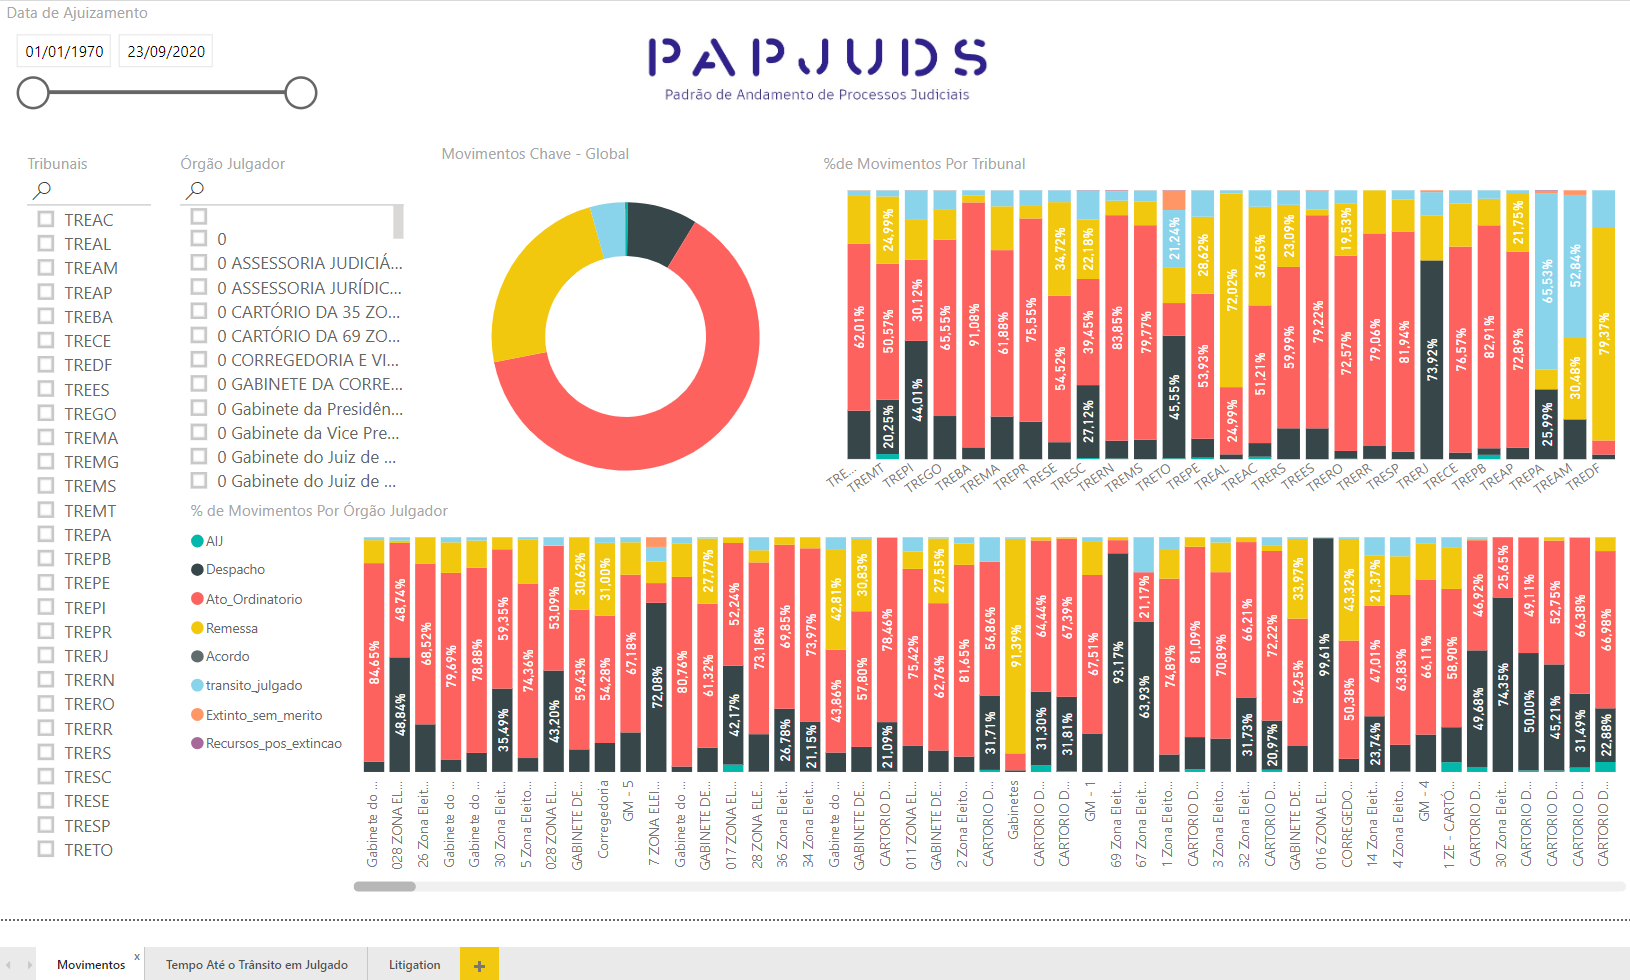

Segunda Tela: Tempo médio de processo até o trânsito em julgado por Tribunal e Classe Processual:

Objetivo: Identificar o tempo que durará um processo nos tribunais e classes processuais, baseado na média histórica.

*   Transito em Julgado


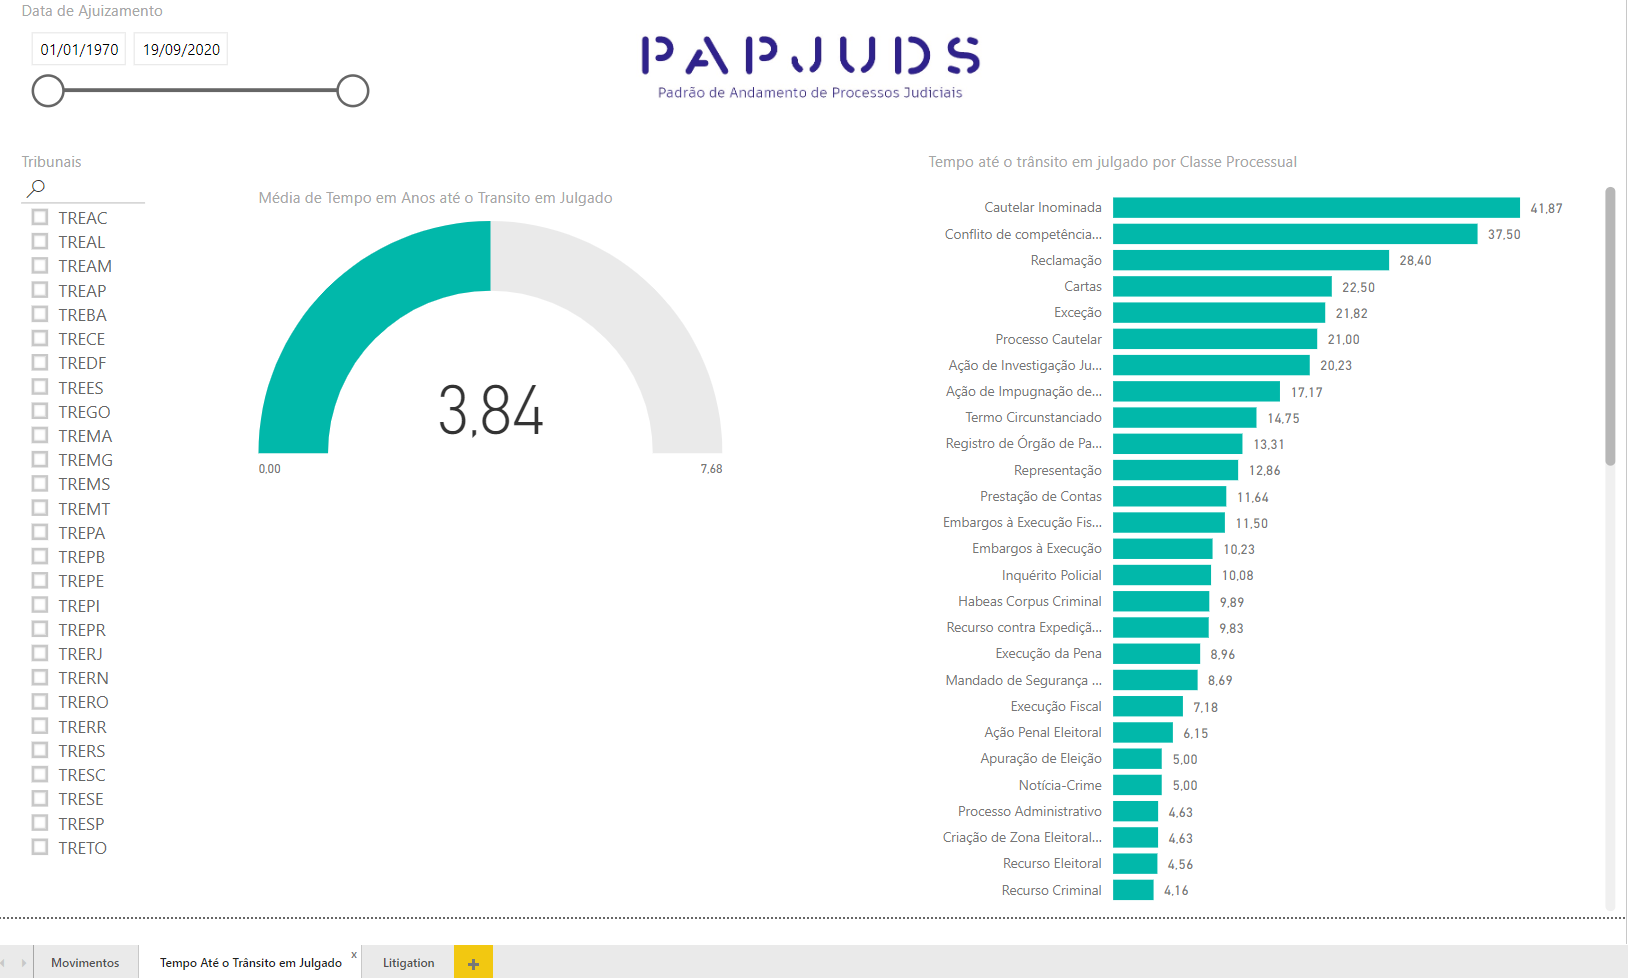

Terceira Tela: Litigation por Tribunal e Órgão Julgador

Objetivo: Identificar se há um desbalanceamento de remessas por jurisdição, o que pode refletir em gargalos nos tribunais superiores e na justiça como um sistema integrado.

*   Litigation = Processos Ativos + Remessas

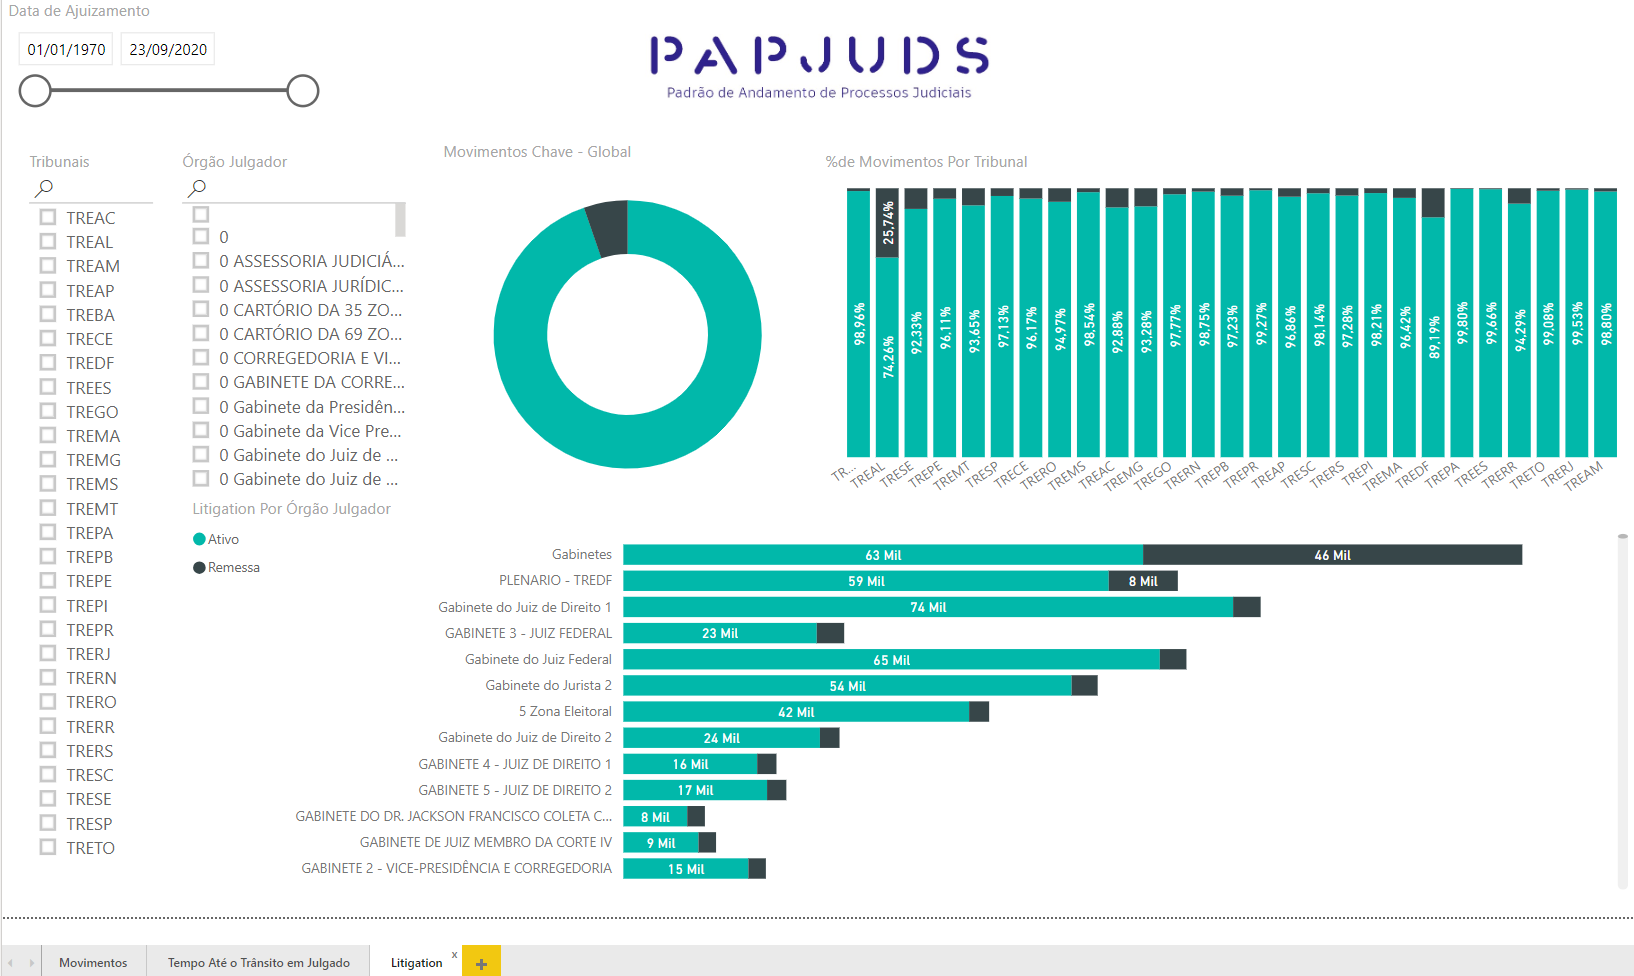